In [3]:
from tensorflow.keras import layers, Model, preprocessing
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.optimizers import Adam
import numpy as np

from utils import make_predictions, evaluation, data_loader

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [4]:
train_ds, val_ds, test_ds, class_names, image_size = data_loader.load_data(RANDOM_SEED, True, 0.75)

Found 15780 files belonging to 11 classes.
Using 11046 files for training.
Found 15780 files belonging to 11 classes.
Using 4734 files for validation.

Classes: ['tomato Fusarium Wilt', 'tomato spider mites', 'tomato verticillium wilt', 'tomato_bacterial_spot', 'tomato_early_blight', 'tomato_healthy_leaf', 'tomato_late_blight', 'tomato_leaf_curl', 'tomato_leaf_miner', 'tomato_leaf_mold', 'tomato_septoria_leaf']

✅ Balanced minority-only augmentation is ON

Counting class frequencies...
tomato Fusarium Wilt: 292
tomato spider mites: 456
tomato verticillium wilt: 376
tomato_bacterial_spot: 1201
tomato_early_blight: 1368
tomato_healthy_leaf: 1311
tomato_late_blight: 982
tomato_leaf_curl: 1335
tomato_leaf_miner: 1289
tomato_leaf_mold: 1342
tomato_septoria_leaf: 1094

Minority class: tomato Fusarium Wilt (count=292) → repeating 4× with augmentation

Minority class: tomato spider mites (count=456) → repeating 3× with augmentation

Minority class: tomato verticillium wilt (count=376) → repeat

In [5]:
# efficientnet base model

efficientNetBaseArchitecture = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(image_size[0], image_size[1], 3),
    pooling='avg'
)

# Freezing the early layers (retain general features)
efficientNetBaseArchitecture.trainable = True
for layer in efficientNetBaseArchitecture.layers:
    # All layers before 'block7a_expand_conv' are frozen
    if layer.name == 'block7a_expand_conv':
        break
    layer.trainable = False

# Custom classification head
x = efficientNetBaseArchitecture.output
x = layers.Dense(256, activation='relu')(x)
predictions = layers.Dense(len(class_names), activation='softmax')(x)

efficientNet = Model(inputs=efficientNetBaseArchitecture.input, outputs=predictions)

efficientNet.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

efficientNet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0]']      

In [6]:
history = efficientNet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
425/425 [==============================] - 383s 864ms/step - loss: 0.5915 - accuracy: 0.8510 - val_loss: 0.7450 - val_accuracy: 0.7834
Epoch 2/10
425/425 [==============================] - 380s 886ms/step - loss: 0.1144 - accuracy: 0.9684 - val_loss: 0.5410 - val_accuracy: 0.8606
Epoch 3/10
425/425 [==============================] - 373s 869ms/step - loss: 0.0650 - accuracy: 0.9815 - val_loss: 0.4136 - val_accuracy: 0.8885
Epoch 4/10
425/425 [==============================] - 385s 897ms/step - loss: 0.0421 - accuracy: 0.9886 - val_loss: 0.4346 - val_accuracy: 0.8982
Epoch 5/10
425/425 [==============================] - 370s 861ms/step - loss: 0.0307 - accuracy: 0.9923 - val_loss: 0.3258 - val_accuracy: 0.9117
Epoch 6/10
425/425 [==============================] - 370s 863ms/step - loss: 0.0237 - accuracy: 0.9935 - val_loss: 0.3056 - val_accuracy: 0.9172
Epoch 7/10
425/425 [==============================] - 364s 848ms/step - loss: 0.0210 - accuracy: 0.9947 - val_loss: 0.2780 -

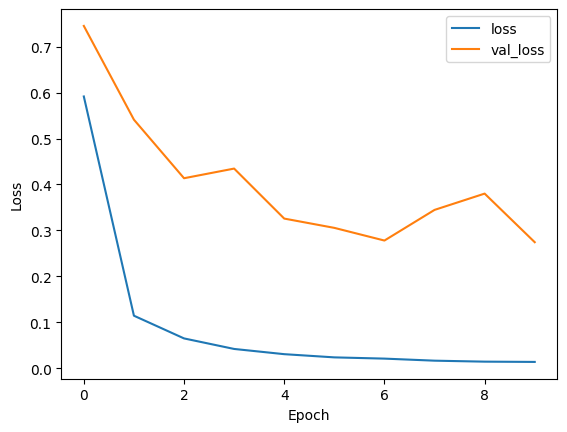

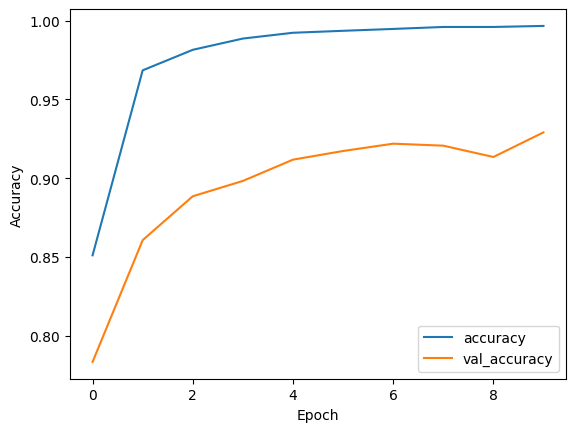

In [7]:
evaluation.plot_loss(history)
evaluation.plot_accuracy(history)

In [8]:
y_true, y_pred = make_predictions.predict_test_data(efficientNet, test_ds)

1/1 [==============================] - 1s 994ms/step


In [9]:
evaluation.make_classification_report(y_true, y_pred, class_names)

                          precision    recall  f1-score   support

    tomato Fusarium Wilt       1.00      0.93      0.96        55
     tomato spider mites       1.00      0.72      0.84        93
tomato verticillium wilt       0.96      1.00      0.98        69
   tomato_bacterial_spot       0.99      1.00      0.99       263
     tomato_early_blight       0.76      1.00      0.86       296
     tomato_healthy_leaf       0.99      1.00      0.99       284
      tomato_late_blight       1.00      0.37      0.54       227
        tomato_leaf_curl       0.99      1.00      1.00       271
       tomato_leaf_miner       1.00      0.99      1.00       299
        tomato_leaf_mold       0.83      1.00      0.91       284
    tomato_septoria_leaf       0.97      1.00      0.98       225

                accuracy                           0.93      2366
               macro avg       0.95      0.91      0.91      2366
            weighted avg       0.94      0.93      0.92      2366


Overal

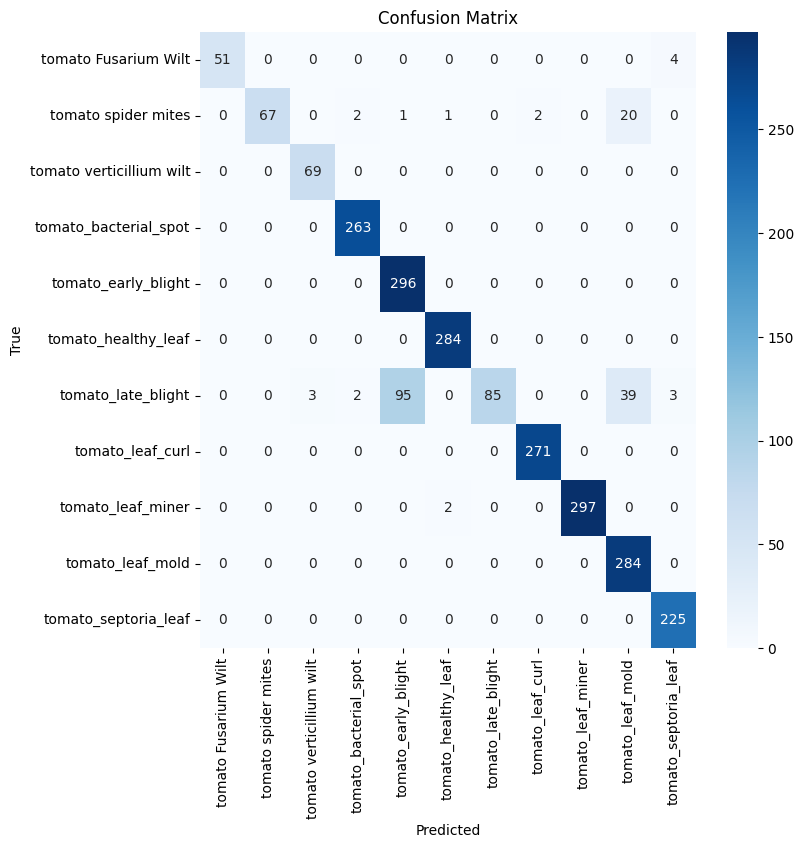

In [10]:
evaluation.make_confusion_matrix(y_true, y_pred, class_names)